## **Toxic Comments Classification**

### Part 4 - Using Pre-Trained (GloVe) Word Embeddings

In [1]:
# general data wrangling etc
import math
import numpy as np
import pandas as pd
import time

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# general text pre & postprocessing
import nltk
from nltk.tokenize import RegexpTokenizer
import re

# modelling
from gensim import models as gensim_models
from sklearn import metrics as smetrics, model_selection
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras import backend as K, callbacks, initializers, layers, losses, metrics as kmetrics, models, \
    optimizers, preprocessing

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('wordnet2022')

# fix a wordnet error
!cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package wordnet2022 to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/wordnet2022.zip.


In [3]:
# load the data
train = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
test = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')

test_labels = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip')
test_labels.drop('id', inplace=True, axis=1)

test = pd.concat([test, test_labels], axis=1)
# remove any unlabelled data
test = test.loc[test.toxic != -1, ]

# convert to a binary classification problem
for df in [train, test]:
    int_cols = df.columns[2:]
    df['toxic_sum'] = df[int_cols].sum(axis=1)
    df['is_toxic'] = df.apply(lambda x: 1 if x['toxic_sum'] > 0 else 0, axis=1)
    
    df.drop('toxic_sum', axis=1, inplace=True)
    
# preprocess the text data
def preprocess_text(text, remove_num=False, remove_sw=False, sw_lst=None, lemm=True, stem=False,
                    remove_single=True):

    # remove numbers
    if remove_num:
        text = re.sub(r'[\s\d+\s]', ' ', text)
        
    # convert strings to lowercase
    text = str(text).lower()
    
    # tokenise the strings
    tokeniser = RegexpTokenizer(r'\w+')
    tokenised_text = tokeniser.tokenize(text)
    
    # remove stopwords
    if remove_sw:
        tokenised_text = [token for token in tokenised_text if token not in sw_lst]
        
    # lemmatise (convert the word into root word)
    if lemm:
        lemmatiser = nltk.stem.wordnet.WordNetLemmatizer()
        tokenised_text = [lemmatiser.lemmatize(token) for token in tokenised_text]

    # stem (remove -ing, -ly, ...)
    if stem:
        stemmer = nltk.stem.porter.PorterStemmer()
        tokenised_text = [stemmer.stem(token) for token in tokenised_text]    

    # remove single-letter words
    if remove_single:
        tokenised_text = [token for token in tokenised_text if len(token) > 1]
    
    # join back together
    text = " ".join(tokenised_text)
    
    return text

# use the nltk stopwords list
stopword_lst = nltk.corpus.stopwords.words("english")

# select just the text and target columns
cols = ['is_toxic', 'comment_text']

train_data = train.loc[:, cols]
test_data = test.loc[:, cols]

start_time = time.time()

# process the data
train_data['processed_comment_text'] = train_data['comment_text'].apply(lambda x: preprocess_text(
    x, remove_num=True, remove_sw=True, sw_lst=stopword_lst, lemm=True, stem=False,
    remove_single=False))
test_data['processed_comment_text'] = test_data['comment_text'].apply(lambda x: preprocess_text(
    x, remove_num=True, remove_sw=True, sw_lst=stopword_lst, lemm=True, stem=False,
    remove_single=False))

end_time = time.time()
print('Elapsed time: {:.2f} minutes'.format((end_time-start_time)/60))

# check the target class balance
train_data.is_toxic.value_counts(normalize=True)

Elapsed time: 1.43 minutes


0    0.898321
1    0.101679
Name: is_toxic, dtype: float64

In [4]:
# rebalance the dataset
clean_texts = train_data[train_data.is_toxic == 0]
train_texts = train_data[train_data.is_toxic == 1]

# randomly sample from the majority class until it makes up only 80% of the dataset
to_conserve = clean_texts.sample(frac=0.42)
train_data_rs = to_conserve.append(train_texts, ignore_index=True)
# re-check the balance
train_data_rs.is_toxic.value_counts(normalize=True)

0    0.787714
1    0.212286
Name: is_toxic, dtype: float64

In [5]:
# split the training data into a train and validation set
X_train_rs, X_valid_rs, y_train_rs, y_valid_rs = model_selection.train_test_split(
    train_data_rs.processed_comment_text,
    train_data_rs.is_toxic,
    train_size=0.8,
    stratify=train_data_rs.is_toxic,
    shuffle=True)

In [6]:
corpus = X_train_rs

# split the text strings into tokens
tokeniser = preprocessing.text.Tokenizer(split=' ', oov_token="NaN")
# construct the word index
tokeniser.fit_on_texts(corpus)
token_index = tokeniser.word_index # this is the vocabulary
total_tokens = len(token_index)+1 #+1 for padding (need this for the model)

# convert the text data to sequences (integer lists)
train_sequences = tokeniser.texts_to_sequences(corpus)

# check the length of the sequences
# we need to pad them so they're all of the same length, but don't want to unecessarily pad short ones
# or cut short too many long ones
lengths = ([len(seq) for seq in train_sequences])
maxlen = np.max(lengths)
qlen = np.quantile(lengths, 0.75)
# this rounds maxlen or qlen up to the nearest 10
padlen = int(math.ceil(qlen / 10.0)) * 10

# pad the sequences to 2D integer tensors of the same length
X_train = preprocessing.sequence.pad_sequences(train_sequences, maxlen=padlen)


# repeat for the validation data
corpus = X_valid_rs

# convert the text to sequences and pad
valid_sequences = tokeniser.texts_to_sequences(corpus)
X_valid = preprocessing.sequence.pad_sequences(valid_sequences, maxlen=padlen)


# ... and for the test data
corpus = test_data.processed_comment_text

# convert the text to sequences and pad
test_sequences = tokeniser.texts_to_sequences(corpus)
X_test = preprocessing.sequence.pad_sequences(test_sequences, maxlen=padlen)

# recall that we don't resample the test data

In [7]:
# # download glove vectors and unzip
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove*.zip

# create a dictionary mapping the words to their numpy vector representation
embeddings_dict = {}
with open('../working/glove.6B.200d.txt', 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector
        
print("Found %s word vectors." % len(embeddings_dict))

Found 400000 word vectors.


In [8]:
# create the embedding matrix to be used in the neural network
# entry at index i is the pre-trained vector for the word of index i in the vocabulary
num_tokens = len(token_index) + 1
embedding_dim = 200
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in token_index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        # words not found in the GlOve dictionary will be all zeros
        # includes representations for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        
print("Converted %d words (%d misses)" % (hits, misses))

Converted 55346 words (34749 misses)


In [9]:
word = "data"

print("dic[word]:", token_index[word], "|idx")
print("embeddings[idx]:", embedding_matrix[token_index[word]].shape, "|vector")

dic[word]: 778 |idx
embeddings[idx]: (200,) |vector


*The code below defines a custom attention layer in Keras. The attention layer takes an input tensor x and returns an output tensor that has been weighted by attention scores. An attention layer enables the model to focus on different parts of the input sequence depending on their relevance to the task at hand.*

The attention scores are calculated using a trainable weight matrix W and bias vector b. The matrix W has shape (input_shape[-1], 1) and is initialised randomly from a normal distribution. The bias vector b has shape (input_shape[1], 1) and is initialized to all zeros.

The attention scores are computed by taking the dot product of the input tensor x with the weight matrix W, adding the bias vector b, and applying the hyperbolic tangent activation function. The resulting tensor e has shape (batch_size, sequence_length, 1).

The attention scores are then normalised using the softmax function along the sequence dimension (axis 1). The resulting tensor a has the same shape as e and contains the attention weights.

Finally, the output tensor is obtained by element-wise multiplication of the input tensor x with the attention weights a. If return_sequences is True, the output tensor has the same shape as the input tensor x. If return_sequences is False, the output tensor is a vector of shape (batch_size, input_shape[-1]), obtained by summing over the sequence dimension (axis 1).

In [10]:
class Attention(layers.Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention,self).__init__()
        
    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1), initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1), initializer="zeros")
        super(Attention,self).build(input_shape)
        
    def call(self, x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

In [11]:
# deine the evaluation metrics
METRICS = [
    kmetrics.AUC(name='prc', curve='PR'),
    kmetrics.AUC(name='auc'),
    kmetrics.BinaryAccuracy(name='accuracy')
]

# # fix the bias (optional)
# classes, counts = np.unique(y_train_rs, return_counts=True)
# initial_bias = np.log([counts[1]/counts[0]])
# output_bias = initializers.Constant(initial_bias)

# calculate balanced class weights
# classes, counts = np.unique(y_train_rs, return_counts=True)
# total = counts[0] + counts[1]
# weight_for_0 = (1 / counts[0]) * (total / 2.0)
# weight_for_1 = (1 / counts[1]) * (total / 2.0)
# balanced_weights_dict = {0: weight_for_0, 1: weight_for_1}
# balanced_weights_dict

# alternative
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train_rs),
                                                  y=y_train_rs)

# # convert class weights to a dictionary
balanced_weights_dict = dict(enumerate(class_weights))
print('Balanced weights:', balanced_weights_dict)

# calculate inverse frequency weights
total = len(y_train_rs)
unique, counts = np.unique(y_train_rs, return_counts=True)
freqs = counts / total
inv_freqs = 1 / freqs
inv_freqs = inv_freqs / np.sum(inv_freqs)

# combine the class weights with the inverse frequency weights
inverse_weights = np.array(list(balanced_weights_dict.values())) * inv_freqs
inverse_weights_dict = dict(zip(np.unique(y_train_rs), inverse_weights))
print('Inverse weights:', inverse_weights_dict)

Balanced weights: {0: 0.6347479445228802, 1: 2.355315870570108}
Inverse weights: {0: 0.13474794452288016, 1: 1.855315870570108}


A focal loss function is designed to address the problem of class imbalance in binary classification tasks. In class-imbalanced problems, the model may become overly biased towards the majority class and perform poorly on the minority class. This is a common problem in many real-world scenarios where positive cases are rare.

The focal loss function is a modification of the standard cross-entropy loss that down-weights the loss assigned to well-classified ('easy') examples, while putting more emphasis on misclassified ('hard') examples.

In [16]:
# define a 'simple' model architecture
# input layer
inputs = layers.Input(shape=(padlen,))
# embedding layer
# input dim: vocab_size + 1
# outut dim: dimension of the dense embedding
x = layers.Embedding(input_dim=embedding_matrix.shape[0],
                     output_dim=embedding_matrix.shape[1],
                     weights=[embedding_matrix],
                     input_length=padlen,
                     trainable=False)(inputs)
# attention layer
x = Attention(return_sequences=True)(x)
# bidirectional lstm layers
x = layers.Bidirectional(layers.LSTM(128, dropout=0.2, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(128, dropout=0.2))(x)
# dense layers
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

# compile model
model = models.Model(inputs, outputs)
# compile with focal loss instead of typical 'binary_crossentropy'
model.compile(loss='binary_focal_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=METRICS)

model.summary()

# add a callback
es = callbacks.EarlyStopping(monitor='val_prc', mode='max', verbose=1, patience=5)

# fit the model to the training data
start_time = time.time()

history = model.fit(X_train, y_train_rs, batch_size=64, epochs=20, validation_data=(X_valid, y_valid_rs),
                    verbose=1, callbacks=[es], class_weight=balanced_weights_dict)

end_time = time.time()
print('Elapsed time: {:.2f} minutes'.format((end_time-start_time)/60))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 40, 200)           18031200  
                                                                 
 attention_1 (Attention)     (None, 40, 200)           240       
                                                                 
 bidirectional_2 (Bidirectio  (None, 40, 256)          336896    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                1644

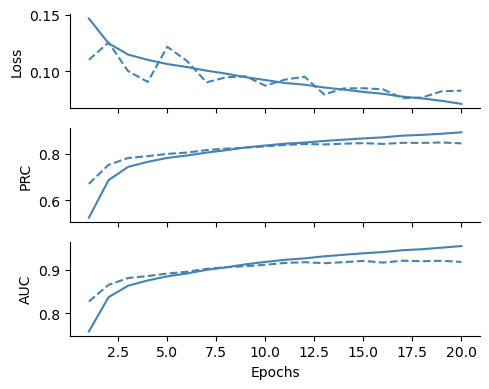

In [17]:
metrics = [k for k in history.history.keys() if ("loss" not in k) and ("val" not in k)]

fig, ax = plt.subplots(figsize=(5, 4), nrows=3, ncols=1, sharex=True)
# plot loss
sns.lineplot(x=[i+1 for i in range(len(history.history['loss']))], y=history.history['loss'], ax=ax[0],
             color='steelblue')
sns.lineplot(x=[i+1 for i in range(len(history.history['val_loss']))], y=history.history['val_loss'],
             ax=ax[0], color='steelblue', linestyle='dashed')
ax[0].set(xlabel="Epochs", ylabel="Loss")

# plot PRC
sns.lineplot(x=[i+1 for i in range(len(history.history['prc']))], y=history.history['prc'], ax=ax[1],
             color='steelblue')
sns.lineplot(x=[i+1 for i in range(len(history.history['val_prc']))], y=history.history['val_prc'],
             ax=ax[1], color='steelblue', linestyle='dashed')
ax[1].set(xlabel="Epochs", ylabel="PRC")

# plot AUC
sns.lineplot(x=[i+1 for i in range(len(history.history['auc']))], y=history.history['auc'], ax=ax[2],
             color='steelblue')
sns.lineplot(x=[i+1 for i in range(len(history.history['val_auc']))], y=history.history['val_auc'],
             ax=ax[2], color='steelblue', linestyle='dashed')
ax[2].set(xlabel="Epochs", ylabel="AUC")

fig.tight_layout()
sns.despine()

2000/2000 [==============================] - 14s 6ms/step
AUPRC: 0.68
F1 score: 0.46
AUC: 0.92
Accuracy: 0.8
Detail:
              precision    recall  f1-score   support

           0       0.98      0.79      0.88     57735
           1       0.31      0.88      0.46      6243

    accuracy                           0.80     63978
   macro avg       0.65      0.84      0.67     63978
weighted avg       0.92      0.80      0.84     63978



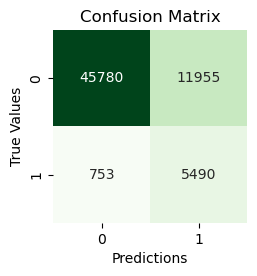

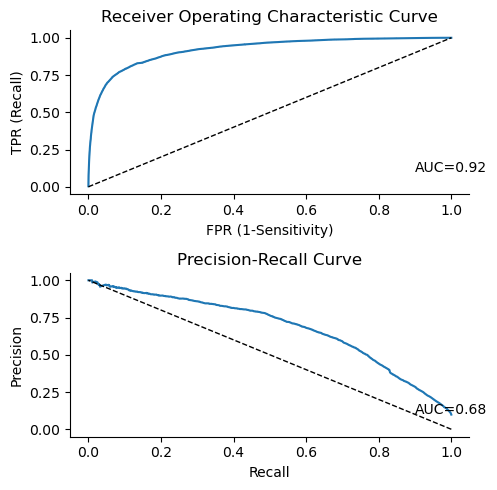

In [18]:
# make predictions on the test set
pred_probs = model.predict(X_test)
preds = (pred_probs > 0.5).astype(int)
y_test = test_data.is_toxic.values

# evaluate model performance
auc = smetrics.roc_auc_score(y_test, pred_probs)
f1 = smetrics.f1_score(y_test, preds)
auprc = smetrics.average_precision_score(y_test, pred_probs)
accuracy = smetrics.accuracy_score(y_test, preds)

print("AUPRC:", round(auprc, 2))
print("F1 score:", round(f1, 2))
print("AUC:", round(auc, 2))
print("Accuracy:", round(accuracy, 2))
print("Detail:")
print(smetrics.classification_report(y_test, preds))

cm = smetrics.confusion_matrix(y_test, preds)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Greens, cbar=False)
plt.xlabel("Predictions")
plt.ylabel("True Values")
plt.title("Confusion Matrix")

fig, ax = plt.subplots(figsize=(5, 5), nrows=2, ncols=1)
# plot precision-recall curve
precision, recall, thresholds = smetrics.precision_recall_curve(y_test, pred_probs)
sns.lineplot(x=recall, y=precision, ax=ax[1])
ax[1].text(x=0.9, y=0.1, s='AUC={0:0.2f}'.format(auprc))
ax[1].plot([1,0], [0,1], color='black', linestyle='--', lw=1)
ax[1].set(xlabel="Recall",
          ylabel="Precision",
          title="Precision-Recall Curve")

# plot roc curve
fpr, tpr, thresholds = smetrics.roc_curve(y_test, pred_probs)
sns.lineplot(x=fpr, y=tpr, ax=ax[0])
ax[0].text(x=0.9, y=0.1, s='AUC={0:0.2f}'.format(auc))
ax[0].plot([0,1], [0,1], color='black', linestyle='--', lw=1)
ax[0].set(xlabel="FPR (1-Sensitivity)",
          ylabel="TPR (Recall)",
          title="Receiver Operating Characteristic Curve")

fig.tight_layout()
sns.despine()

The performance is again ok, but not great.